[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Estimate Vehicle Speed with Computer Vision

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/uWP6UjDeZvY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision/tree/develop/examples/speed_estimation)

## Accompanying Materials

We recommend that you follow along in this notebook while watching the YouTube [tutorial](https://youtu.be/uWP6UjDeZvY) on how to estimate vehicle speed with computer vision. You can also find the code below in Python script form as one of the [supervision/examples](https://github.com/roboflow/supervision/tree/develop/examples).

[![YouTube Video](https://github.com/SkalskiP/SkalskiP/assets/26109316/61a444c8-b135-48ce-b979-2a5ab47c5a91)](https://youtu.be/uWP6UjDeZvY)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install
- Imports
- Download Data
- Configuration
- Source and Target ROIs
- Transform Perspective
- Process Video

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 18 11:34:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install

In [15]:
!pip install ultralytics

## Imports

In [3]:
!pip install overwatch-sayak

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 4.7 MB/s eta 0:00:00


In [4]:
import cv2

import numpy as np

import overwatch_sayak as ov

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

## Download Data

## Configuration

In [6]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [7]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [8]:
frame_generator = ov.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

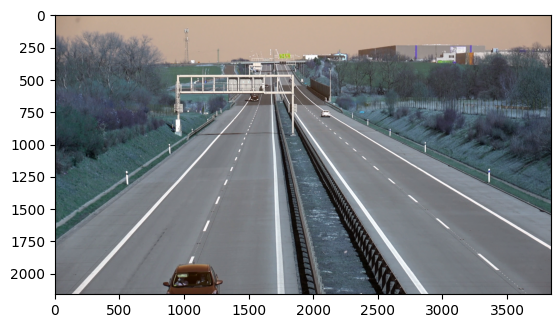

In [14]:
# prompt: show the frame in form of image

import matplotlib.pyplot as plt

plt.imshow(frame)
plt.show()

OverwatchWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `overwatch-0.22.0`. Use `Color.RED` instead.


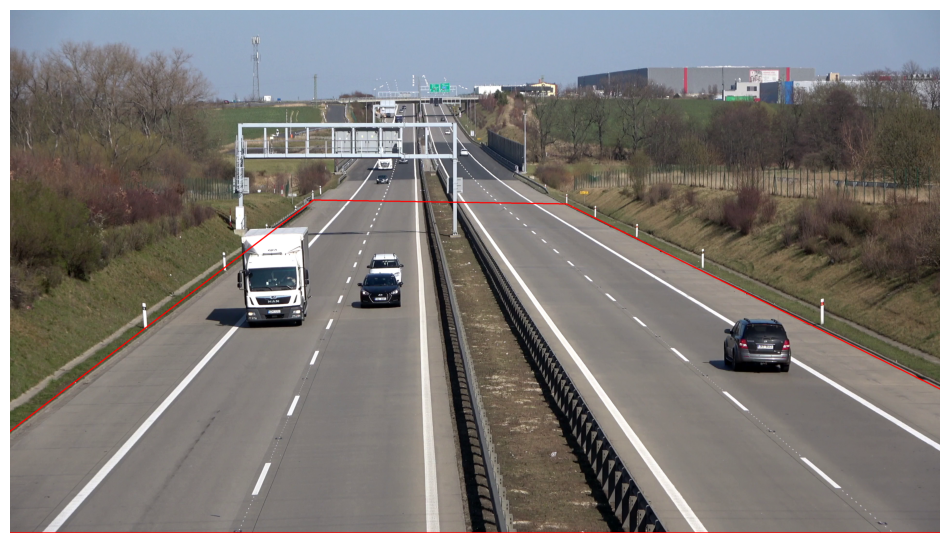

In [9]:
annotated_frame = frame.copy()
annotated_frame = ov.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=ov.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [10]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [11]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [13]:
model = YOLO(MODEL_NAME)

video_info = ov.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = ov.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = ov.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = ov.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = ov.calculate_optimal_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = ov.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = ov.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=ov.Position.BOTTOM_CENTER
)
trace_annotator = ov.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=ov.Position.BOTTOM_CENTER
)

polygon_zone = ov.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = ov.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=ov.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

OverwatchWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `overwatch-0.23.0`. Use 'track_activation_threshold' instead.
OverwatchWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version overwatch-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 538/538 [02:09<00:00,  4.17it/s]
